In [46]:
import collections
import tensorflow as tf
import numpy as np
import random
from six.moves import xrange 
import math
from tempfile import gettempdir
import os

In [25]:
corpus=open('avengers.txt','r').read()
vocab=corpus.split(' ')

#len(set(vocab))        
limit_vocab=5000
def build_dataset(words,n_words):
    count=[['UNK',-1]]
    count.extend(collections.Counter(words).most_common(n_words-1))
    dictionary={}
    unk_count=0
    for word,_ in count:
        dictionary[word]=len(dictionary)
    data=[]
    for word in words:
        index=dictionary.get(word,0)
        if index==0:
            unk_count+=1
        data.append(index)    
    reversed_dictionary=dict(zip(dictionary.values(),dictionary.keys()))
    count[0][1]=unk_count
    return count,data,reversed_dictionary,dictionary
count,data,reversed_dictionary,dictionary=build_dataset(vocab,limit_vocab)

vocabulary_size=limit_vocab

In [26]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
                       
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
       data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
      context_words = [w for w in range(span) if w != skip_window]
      words_to_use = random.sample(context_words, num_skips)
      for j, context_word in enumerate(words_to_use):
        batch[i * num_skips + j] = buffer[skip_window]
        labels[i * num_skips + j, 0] = buffer[context_word]
      if data_index == len(data):
        buffer.extend(data[0:span])
        data_index = span
      else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

 
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)     


In [31]:
batch_size=128  
embedding_size=128
skip_window=1         #How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
neg_samples=64        #negative examples for loss functions
valid_size = 16     # Random set of words to evaluate similarity on.

valid_window = 100  # Only pick dev samples in the head of the distribution.

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph=tf.Graph()
with graph.as_default():
     # Input data.
     train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
     train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
     valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
     with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
                              tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
     # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
     loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=neg_samples,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
     optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
  # Compute the cosine similarity between minibatch examples and all embeddings.
     norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
     normalized_embeddings = embeddings / norm
     valid_embeddings = tf.nn.embedding_lookup(
     normalized_embeddings, valid_dataset)
     similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

 
    # Add variable initializer.
     init = tf.global_variables_initializer()




In [41]:

# Begin training.
num_steps = 100001
with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reversed_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reversed_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)

  final_embeddings = normalized_embeddings.eval()
        

Initialized
Average loss at step  0 :  192.428405762
Nearest to at: wants., AGAINST, ROARS, MONITORS, before?, poisonous, inside, minds,
Nearest to the: stop...

, doctor, behind, night., here.

, schemes!

, MORNING

, parachute,
Nearest to AMERICA
: MJÖLNIR, It
, making, Chitauri, monitor)
, intensity., VII, humans,
Nearest to your: fully, uniform?, silver, AVENGERS

, eight, distance.

, Bad, (covering,
Nearest to was: apart.

, SELVIG)
, Somebody's, is., A., Uh,, she, RADIATION,
Nearest to in: cooperate.

, you're, WHICH, trap., BARRELS, billionaire,, hand, FLOOR,,
Nearest to NICK: gods.

, talk., lab.Then...

, slights.
, face.

, build, FIRST, puts
,
Nearest to his: bellows, king
, superhero., Spontaneous, I?, funny?

, Standing, RUSSIAN.

,
Nearest to as: releases., usual.
, shakes, 39th.

, minutes,, hooks, thing, drew,
Nearest to a: mountain, HELICARRIER, going, middle, survivors.

, CHAOS., uh..., weep,
Nearest to : MIGHT,, LEDGE, releases., knowledge,
, brush.

, Barton.

, 

Average loss at step  52000 :  2.83176739705
Average loss at step  54000 :  2.28166551897
Average loss at step  56000 :  2.56724370757
Average loss at step  58000 :  2.35660466444
Average loss at step  60000 :  2.40327973747
Nearest to at: wants., PHIL, toward, and, middle, Uh..., to, front,,
Nearest to the: time.
, ­, that, your, taking, SMASHING
, Romanoff,, beautiful,
Nearest to AMERICA
: MJÖLNIR, It
, Just, Nuclear, SCEPTER., SKY, sir., fire,,
Nearest to your: photo, open,, the, got, AVENGERS

, DRAKOV'S, silver, have,
Nearest to was: is., she, Councilman?, reaches, Steve.

, apart.

, Somebody's, tourist.
,
Nearest to in: into, caught, WIDOW, to, BREATHING, never, is, up,
Nearest to NICK: talk., gods.

, slights.
, desert, impossible, DAY, tourist.
, lab.Then...

,
Nearest to his: her, their, bellows, nods, back, lying, it, can
,
Nearest to as: minutes,, city., cut, wants., and, ­, thing, button,
Nearest to a: mountain, answer.

, looks, PHIL, many, it...

, an, swerving,
Nearest 

In [42]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

        plt.savefig(filename)


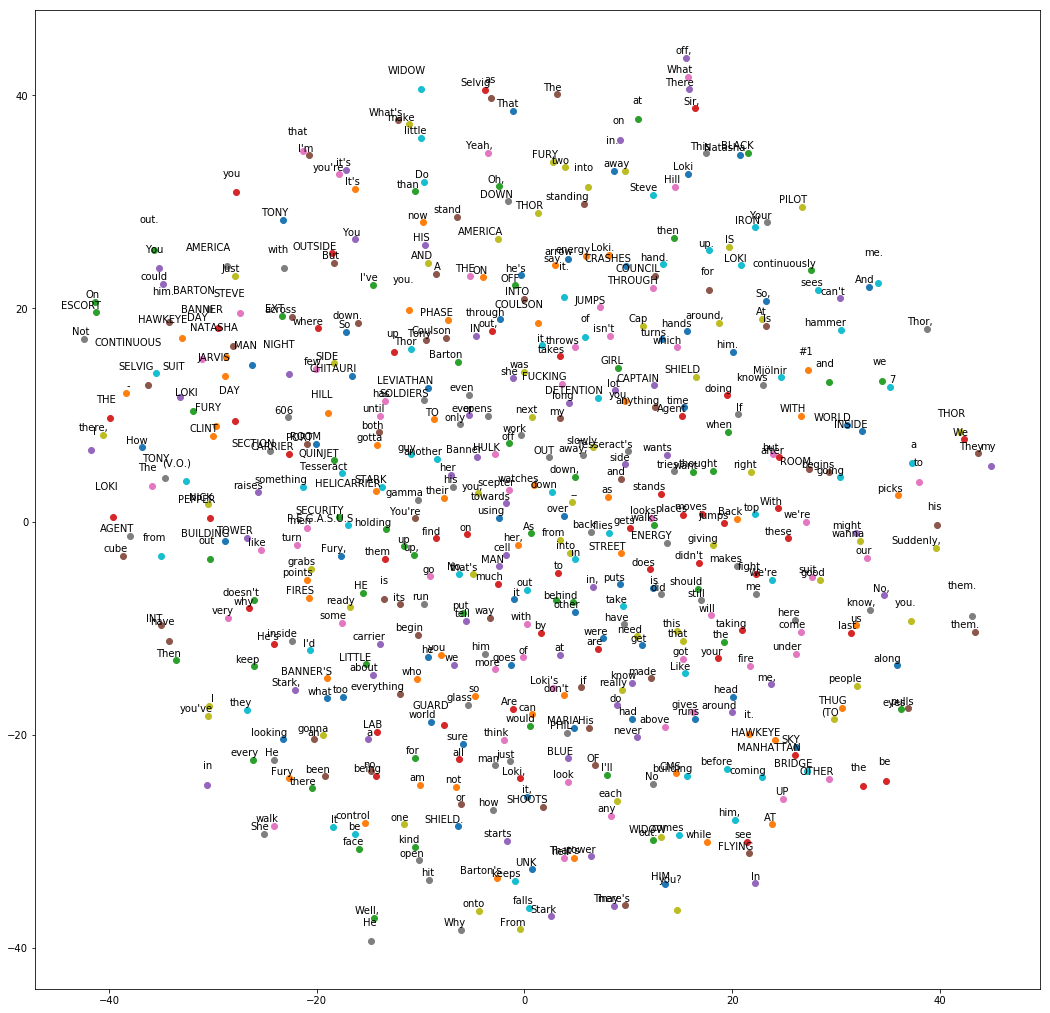

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reversed_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))